# 뉴스 카테고리 분류 모델
- [대회 데이터 다운 링크](https://dacon.io/competitions/official/235747/data)
- `private score : 0.67608` , `public score : 0.70427`
- 사용 모델 : GRU

누구나 이해하기 쉽게 가장 간단하게 설계한 모델입니다.   
참고사이트 : [위키 독스](https://wikidocs.net/65348)


In [5]:
import pandas as pd

train = pd.read_csv('data/train_data.csv')
test = pd.read_csv('data/test_data.csv')

In [6]:
train.head()

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [7]:
from torchtext.legacy import data 
from konlpy.tag import Okt

tokenizer = Okt()

In [8]:
def get_length(title):
    return len(title)

train['title_len'] = train['title'].apply(get_length)

<AxesSubplot:xlabel='title_len', ylabel='Count'>

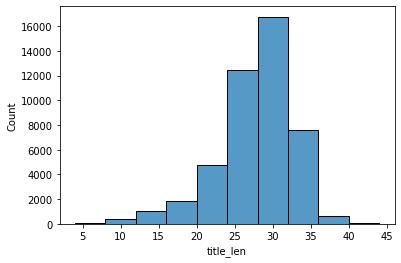

In [10]:
import seaborn as sns
import numpy as np 




np.median(train['title_len'].to_list())
np.max(train['title_len'].to_list())

sns.histplot(train['title_len'],bins = 10)


In [11]:
# 필드 정의

# 실제 사용은 하지 않을 예정
INDEX = data.Field(sequential = False,
                use_vocab = False)

TITLE = data.Field(sequential=True,
                  use_vocab=True,
                  tokenize=tokenizer.morphs, # 토크나이저로는 Okt 사용.
                  lower=True,
                  batch_first=True,
                  fix_length=44)

LABEL = data.Field(sequential=False,
                   use_vocab=False,
                   is_target=True)

## 데이터셋 만들기

In [12]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

for i,(trn_idx,val_idx) in enumerate(skf.split(train['title'],train['topic_idx'])):
    trn = train.iloc[trn_idx]
    val = train.iloc[val_idx]

In [13]:
trn.to_csv('data/trn.csv',index = False)
val.to_csv('data/val.csv',index = False)

In [14]:
test['topic_idx'] = 0
test.to_csv('data/test.csv',index = False)

In [15]:
from torchtext.legacy.data import TabularDataset

train_data, validation_data,test_data =TabularDataset.splits(
     path='data/', train='trn.csv',validation= 'val.csv', test='test.csv', format='csv',
        fields=[('index', INDEX), ('title', TITLE), ('topix_idx', LABEL)], skip_header=True)


In [16]:
print('훈련 샘플의 개수 : {}'.format(len(train_data)))
print('검증 샘플의 개수 : {}'.format(len(validation_data)))
print('테스트 샘플의 개수 : {}'.format(len(test_data)))

훈련 샘플의 개수 : 36524
검증 샘플의 개수 : 9130
테스트 샘플의 개수 : 9131


In [17]:
TITLE.build_vocab(train_data, min_freq = 2, max_size = 20000)

In [18]:
print('단어 집합의 크기 : {}'.format(len(TITLE.vocab)))

단어 집합의 크기 : 18587


## 데이터 로더 만들기

In [19]:
from torchtext.legacy.data import Iterator

In [42]:
# 하이퍼파라미터
batch_size = 128
lr = 0.001
EPOCHS = 20

In [43]:
train_loader = Iterator(dataset = train_data, batch_size = batch_size)
val_loader = Iterator(dataset = validation_data, batch_size = batch_size)
test_loader = Iterator(dataset = test_data, batch_size = batch_size,shuffle = False)

In [44]:
print('훈련 데이터의 미니 배치 수 : {}'.format(len(train_loader)))
print('검증 데이터의 미니 배치 수 : {}'.format(len(val_loader)))
print('테스트 데이터의 미니 배치 수 : {}'.format(len(test_loader)))

훈련 데이터의 미니 배치 수 : 286
검증 데이터의 미니 배치 수 : 72
테스트 데이터의 미니 배치 수 : 72


## GRU 모델 구현

In [45]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data, datasets
import random

In [46]:
class GRU(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, dropout_p=0.2):
        super(GRU, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embed = nn.Embedding(n_vocab, embed_dim)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(embed_dim, self.hidden_dim,
                          num_layers=self.n_layers,
                          batch_first=True)
        self.out = nn.Linear(self.hidden_dim, n_classes)

    def forward(self, x):
        x = self.embed(x)
        h_0 = self._init_state(batch_size=x.size(0)) # 첫번째 히든 스테이트를 0벡터로 초기화
        x, _ = self.gru(x, h_0)  # GRU의 리턴값은 (배치 크기, 시퀀스 길이, 은닉 상태의 크기)
        h_t = x[:,-1,:] # 모든 문장을 거쳐서 나온 가장 마지막에 나온 단어(평점)의 값
        self.dropout(h_t)
        logit = self.out(h_t)  # (배치 크기, 은닉 상태의 크기) -> (배치 크기, 출력층의 크기)
        return logit

    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()

In [47]:
def train(model, optimizer, train_iter):
    """모델 학습"""
    model.train()
    for i, batch in enumerate(train_iter):
        x, y = batch.title.to(DEVICE), batch.topix_idx.to(DEVICE)
        
        
        optimizer.zero_grad()

        logit = model(x)
        y= torch.tensor(y,dtype = torch.long,device =DEVICE)

        loss = F.cross_entropy(logit,y)
        loss.backward()
        optimizer.step()

In [48]:
def evaluate(model, val_iter):
    """검증 데이터셋 평가"""
    model.eval()
    batch_cor, total_loss = 0, 0
    
    for batch in val_iter:
        x, y = batch.title.to(DEVICE), batch.topix_idx.to(DEVICE)
        y= torch.tensor(y,dtype = torch.long,device =DEVICE)
        logit = model(x)
        
        loss = F.cross_entropy(logit, y)
        
        total_loss += loss.item()
        batch_cor += (logit.max(1)[1] == y.data).sum() 
        
    size = len(val_iter.dataset)
    avg_loss = total_loss / size 
    avg_accuracy = 100.0 * batch_cor / size

    
    return avg_loss, avg_accuracy

In [49]:
vocab_size = len(TITLE.vocab) 
n_classes = 7
print('단어 집합의 크기 : {}'.format(vocab_size))
print('클래스의 개수 : {}'.format(n_classes))

단어 집합의 크기 : 18587
클래스의 개수 : 7


In [50]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRU(1, 8, vocab_size , 128, n_classes, 0.2).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [51]:
best_val_loss = None
best_model = []

for e in range(1, EPOCHS + 1 ):
    train(model, optimizer, train_loader)
    val_loss, val_accuracy= evaluate(model, val_loader)

    print("[Epoch: %d] val loss : %5.5f | val accuracy : %5.2f" % (e, val_loss, val_accuracy))

    # 검증 오차가 가장 적은 최적의 모델을 저장
    if not best_val_loss or val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


[Epoch: 1] val loss : 0.01439 | val accuracy : 28.57
[Epoch: 2] val loss : 0.01261 | val accuracy : 40.07
[Epoch: 3] val loss : 0.01050 | val accuracy : 51.85
[Epoch: 4] val loss : 0.00904 | val accuracy : 58.74
[Epoch: 5] val loss : 0.00838 | val accuracy : 62.69
[Epoch: 6] val loss : 0.00786 | val accuracy : 67.10
[Epoch: 7] val loss : 0.00762 | val accuracy : 68.60
[Epoch: 8] val loss : 0.00761 | val accuracy : 70.08
[Epoch: 9] val loss : 0.00762 | val accuracy : 70.49
[Epoch: 10] val loss : 0.00763 | val accuracy : 71.23
[Epoch: 11] val loss : 0.00772 | val accuracy : 71.50
[Epoch: 12] val loss : 0.00789 | val accuracy : 71.46
[Epoch: 13] val loss : 0.00810 | val accuracy : 72.25
[Epoch: 14] val loss : 0.00830 | val accuracy : 72.04
[Epoch: 15] val loss : 0.00847 | val accuracy : 71.79
[Epoch: 16] val loss : 0.00867 | val accuracy : 72.38
[Epoch: 17] val loss : 0.00869 | val accuracy : 72.29
[Epoch: 18] val loss : 0.00910 | val accuracy : 72.07
[Epoch: 19] val loss : 0.00920 | val 

In [52]:
def predict(model, test_iter):
    """학습된 모델로 정답 파일 예측"""
    model.eval()
    preds = []
    pred = []
    for batch in test_iter:
        x, y = batch.title.to(DEVICE), batch.topix_idx.to(DEVICE)
        
        logit = model(x)
        pred=torch.argmax(logit,axis= 1).tolist()
        preds.extend(pred)
    return preds 


In [53]:
# bset model로 예측.
pred = predict(best_model,test_loader)
len(pred)

9131

## 정답 파일 생성

In [37]:
submission = pd.read_csv('data/sample_submission.csv')
submission.topic_idx = pred
submission.to_csv('gru.csv',index= False)